## Ecohydrology Spinup

For applications of temperate ecohydrology, spinup is all about getting antecedent soil moisture conditions correct.  There can be no expectation of getting reasonable hydrographs if the antecedent soil moisture field is wrong.

One way of doing this is to solve, to pseudo-steady state, the integrated hydrology problem with a constant source term that is given by the mean annual (or mean seasonal) precipitation minus evapotranspiration (P-ET) rate.  This can be solved for long times, using an adaptive timestep that grows as the solution approaches steady state.  This sets the mean background conditions for simulations with daily or other high-resolution inputs.

Here we do that for a simple hillslope to provide the initial conditions for other runs in this suite.

Author: Ethan Coon

In [1]:
%matplotlib inline
import sys,os
sys.path.append(os.path.join(os.environ['ATS_SRC_DIR'],'tools', 'utils'))
import parse_xmf, parse_ats
import column_data, transect_data
import colors
import mesh
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colorbar

/Users/uec/codes/anaconda/2/5.1.0/base/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


The first step is to provide an initial condition for that run which is hydrostatic with the water table at the surface.  Starting from fully saturated and drawing down to the steady state is faster and more efficient than starting from dry and filling up to the steady state.  To do this, we don't assume that this is a hillslope with fixed slope, but imagine that it is set by topography and therefore cannot be provided analytically.

ATS doesn't currently have a way of setting an initial condition as a function of depth, which would be ideal in this situation (contributions welcome!)  But ATS does support initializing from a column, in which a column solution is draped from the topography across the full mesh.  This is quite simple in this case, because it is hydrostatic and therefore a linear solution.  The file `../data/column_data.h5` provides a working version of this initialization strategy up to 100m soil depth.

In [ ]:
# create the column_data file
import numpy as np
import h5py

rho = 997
g = 9.80665

z = np.array([0, 100])
pres = 101325. + np.array([0.,100.])*rho*g

with h5py.File('../data/column_data.h5', 'a') as fid:
    fid.create_dataset('z', data=z)
    fid.create_dataset('pressure', data=pres)


Given that initial condition, we solve to steady state.  In this solve, we often use a too-large Manning's coefficient.  This slows up the surface water, which is safe to do because we're looking at such long time scales.  Surface water is still much faster than subsurface water, and as long as we aren't trying to get high frequency hydrographs correct, this makes for much faster simulations (with longer timestep sizes) with little loss in predictive power.

This run is for 20,000 days and is plotted below.  The image is a bit hard to see without exaggerating in the vertical -- a better way of seeing these runs is to open it in VisIt.

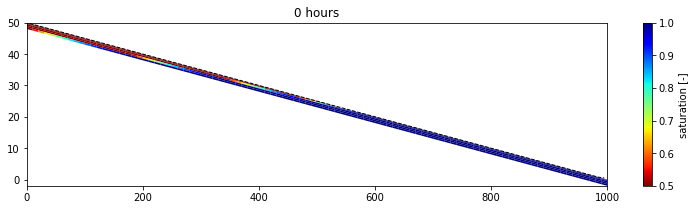

In [3]:
# plot the saturation at a few times
directory = "steadystate_gi.demo"

keys, times, dat = parse_ats.readATS(directory, "visdump_data.h5", timeunits='d')
dats = column_data.column_data(['surface-ponded_depth','surface-elevation'], 
                               directory=directory, filename="visdump_surface_data.h5", 
                               mesh_filename="visdump_surface_mesh.h5", coord=0)

fig, ax = plt.subplots(1,1, figsize=(13,3))

def plot(i, ax):
    cax = colorbar.make_axes(ax, 'right')[0]
    cax.set_ylabel("saturation [-]")

    transect_data.plot(dat["saturation_liquid.cell.0"][keys[i]][:,0], ax, cax,
                       0.5, 1.0, directory=directory, cmap="jet_r", label="saturation [-]", linewidths=0)
    ax.plot(dats[0,0,:], dats[1,i,:]+dats[2,i,:], 'k--', linewidth=1)
    ax.set_title("{0} hours".format(3*i))
    
plot(0, ax)
plt.show()

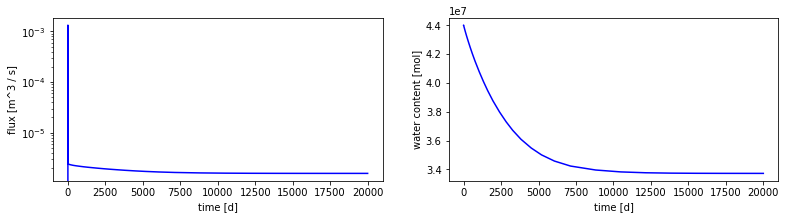

In [5]:
# plot the runoff and, more clearly, the total water content in the subsurface to see if we are at steadystate
fig, ax = plt.subplots(1,2, figsize=(13,3))

flux = np.loadtxt(os.path.join(directory, 'surface_outlet_flux.dat'))
ax[0].semilogy(flux[:,0]/86400., flux[:,1]/55000., 'b')
ax[0].set_xlabel('time [d]')
ax[0].set_ylabel('flux [m^3 / s]')

wc = np.loadtxt(os.path.join(directory, 'water_content.dat'))
ax[1].plot(wc[:,0]/86400., wc[:,1], 'b')
ax[1].set_xlabel('time [d]')
ax[1].set_ylabel('water content [mol]')

plt.show()
